<a href="https://colab.research.google.com/github/nargesalavi/Quantum-Open-Source-Foundation-Mentorship/blob/master/QNN_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Task 1: Quantum Neural Network for State Approximation

In this task, the below neural network is trained to approximate a random quantum state. The aim is to investigate the effect of number of layers in the accuracy of the approximation.

<img src = "Figures/qnn.png" style = "width:400px"/>

<img src = "Figures/layers.png" style = "width:400px"/>

In this project, I use Cirq and Tensorflow Quantum to implement the models.

In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
!pip install tensorflow-quantum

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ln -s "/content/gdrive/My Drive" "/content/mydrive"

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
qubits = cirq.GridQubit.rect(1, 4)

The two following function builds the even and odd layers using parameterized gates.

In [8]:
def generate_even_block(block_number):
    """ Function for generating the even blocks
        Arguments:
          block_number: Block number, it has to be even.
        return: ciq.Circuit """
    params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*4,block_number*4)])

    # create the parameterized circuit
    circuit = cirq.Circuit(
        cirq.rz(params[0])(qubits[0]),
        cirq.rz(params[1])(qubits[1]),
        cirq.rz(params[2])(qubits[2]),
        cirq.rz(params[3])(qubits[3]),
        cirq.CZ(qubits[0],qubits[1]),
        cirq.CZ(qubits[0],qubits[2]),
        cirq.CZ(qubits[0],qubits[3]),
        cirq.CZ(qubits[1],qubits[2]),
        cirq.CZ(qubits[1],qubits[3]),
        cirq.CZ(qubits[2],qubits[3])
    )
    
    return circuit

In [ ]:
def generate_odd_block(block_number):
    """ Function for generating the odd blocks
        block_number: Block number, it has to be odd.
        return: ciq.Circuit """
    params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*4,block_number*4)])

    # create the parameterized circuit
    circuit = cirq.Circuit(
        cirq.rx(params[0])(qubits[0]),
        cirq.rx(params[1])(qubits[1]),
        cirq.rx(params[2])(qubits[2]),
        cirq.rx(params[3])(qubits[3])
    )
    
    return circuit

This function builds the quantum neural network by using the previous generating block functions.

In [ ]:
def generate_qnn(l):
    """ Function for generating qnn, containing l number of layers.
        Arguments:
          l: number of layers, each layer contains one odd and one even block.
        return: ciq.Circuit """
    circuit = cirq.Circuit()
    for i in range(1,2*l+1):
        if i % 2 == 1:
            circuit += generate_odd_block(i)
        else:
            circuit += generate_even_block(i)
        
    return circuit

You can see the QNN, which has one layer, below. Additionally, you can find how the parameters are defined and initialized. For calculating the state of the qnn circuit, I use tfq.layers.State() from TensorFlow Quantum (TFQ).

In [ ]:
l=1
qnn = generate_qnn(l)
print(qnn)

# Defining and Initializing the parameters:
params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) #tf.zeros([1,8*l ], tf.float32)
print('Parameters:\n', params)
params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])

# Calculating the state vector:
state_layer = tfq.layers.State()
state = state_layer(qnn, symbol_names=params_names, symbol_values=params)
print('\nState Vector:\n', state)

                                               ┌──┐
(0, 0): ───Rx(theta_0)───Rz(theta_4)───@───@────@─────────────
                                       │   │    │
(0, 1): ───Rx(theta_1)───Rz(theta_5)───@───┼────┼@────@───────
                                           │    ││    │
(0, 2): ───Rx(theta_2)───Rz(theta_6)───────@────┼@────┼───@───
                                                │     │   │
(0, 3): ───Rx(theta_3)───Rz(theta_7)────────────@─────@───@───
                                               └──┘
Parameters:
 tf.Tensor(
[[2.5443769 6.1479607 3.1814964 5.953483  5.5278993 4.94873   5.0682817
  5.509855 ]], shape=(1, 8), dtype=float32)

State Vector:
 <tf.RaggedTensor [[(0.0026067534927278757-0.00515482435002923j), (0.0009165829396806657-0.0002887023729272187j), (0.2124575525522232-0.19662398099899292j), (-0.04809628054499626-0.0024431594647467136j), (0.00025334247038699687-0.00029802718199789524j), (-6.491901149274781e-05+4.473395165405236e-06j), (-0.0171042960137128

Now, the target state, which the qnn will be trained to approximate, is randomly chosen.

In [22]:
""" cirq.testing.random_circuit is used to generate a random state. The loop is for making sure that all
    the four qubits are involved in random generation."""
while True:
    random_circuit = cirq.testing.random_circuit(qubits = qubits,n_moments = np.random.randint(low=1,high=5),\
                                                                op_density = 0.99999999)
    target_state = tfq.layers.State()(random_circuit)
    
    if target_state[0].shape == 16:
        break

print(random_circuit)
print(target_state)

(0, 0): ───────@───────@───
               │       │
(0, 1): ───X───@───X───@───
                   │
(0, 2): ───X───X───@───T───

(0, 3): ───H───────X───────
<tf.RaggedTensor [[(4.053175895905653e-15-3.0908619663705394e-08j), (2.1424904307409476e-15-3.0908619663705394e-08j), (4.3711395392165286e-08-4.371138118131057e-08j), (4.371139183945161e-08-4.371138473402425e-08j), (0.7071067690849304+1.2363446444396686e-07j), (0.7071067690849304+7.992308326265629e-08j), (-3.821370506812936e-15-3.821371353845884e-15j), (-3.821370506812936e-15-3.821371353845884e-15j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]]>


The following function, calculate the distance between the state vector of the qnn model $|\psi(\theta)>$  and the target state $|\varphi>$:

$\epsilon = min_\theta ||\quad|\psi(\theta)> - |\varphi> ||$.



In [9]:
def states_distance(state,target):
  """ This function calculates the distatnce between state and target by multipltying their differences to
    their conjugates. It is calculated by tf.tensordot with axes = 1, which does the same function as sum
    over all elements of the result of the muliplication of state and target.
    state:  The state vector of the model.
    target: The target state that the aim is to approximate it.
    return: Tensor of float of distance value."""

  diff = state[0] - target[0]
  diff = tf.reshape(diff, [16, 1])
  conjugate_transposed_state = tf.transpose(diff,conjugate=True)
  distance = tf.tensordot(conjugate_transposed_state, diff, axes = 1)

  return tf.dtypes.cast(distance, tf.float32)

In [10]:
def custom_gradient(params, target_state, parameter_shift = True, h = np.pi/2):
  """ This function calculates the gradients of the quantum circuit's parameters 
      using two methods: Parameter shift rules or Numerical differentiation.
      In numerical differentiation method, for Pauli gates the shift value is pi/2 and the ratio is 1/2. 
      Arguments:
        params: circuit's parameters, of which the gradient is calculated.
        target_state: The target state, which the quantum NN trys to approximate.
        parameter_shift: Determine which method is used to calculate the gradients. 
                         When it is True, the function uses parameter shift otherwise it uses numerical differentiation.
        h: The shift value for parameter. When parameter shift method is used, it is pi/2.
        return: list of gradients of distance function, defined above. """
  param_length = len(params[0])
  grad = [None]*param_length
  if parameter_shift : 
    r = 1/2
    h = np.pi/2
  else:
    r = 1/(2*h)
  for i in range(param_length):
    
    params_plus_h = tf.convert_to_tensor([np.concatenate((params[0][0:i],[params[0][i]+h],params[0][i+1:]))])
    params_minus_h = tf.convert_to_tensor([np.concatenate((params[0][0:i],[params[0][i]-h],params[0][i+1:]))])
    state_plus_h = state_layer(qnn, symbol_names=params_names, symbol_values=params_plus_h)
    state_minus_h = state_layer(qnn, symbol_names=params_names, symbol_values=params_minus_h)
    #print('i', i, 'state_plus_h:', state_plus_h, 'state_minus_h:', state_minus_h) 
    grad[i] = r*(states_distance(state_plus_h,target_state)-states_distance(state_minus_h,target_state))

  return grad

In [11]:
def update_params(params, gradients, learning_rate):
  """ This function update parameters for stachastic gradient descent.
    params: Tensor of parameters that will be updated.
    gradients: Tensor of gradients of distance function.
    learning rate: The rate that parameters are updated.
    return: Tensor of updated paramters."""

  gradients = tf.reshape(gradients,[1,len(params[0])])
  params -= learning_rate*gradients
  #params = params % (2*np.pi)
  return params


In [ ]:
L = 10
learning_rate = 0.01
number_of_iteration = 1000
print_step = 100

In [ ]:
list_of_e =[]
types = 1
for l in range(1,L+1):
  print('***** Number of Layers:', l, '*****')
  qnn = generate_qnn(l, types)
  params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) 
  params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])
  eValues = []
  for i in range(number_of_iteration):
    params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/320)
    params = update_params(params, params_grads,learning_rate)

    approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
    e = states_distance(approximation,target_state)
    eValues.append(e[0][0].numpy())

    if i % print_step == 0:
      print('Iteration Number:', i, ', Distance:', e[0][0].numpy())
  print('---Training qnn with ', l, ' layers finished.','Final distance =', e[0][0].numpy(),'.')
  np.savetxt('/content/mydrive/model1_layer_{}'.format(l), eValues, delimiter='\n')
  np.savetxt('/content/mydrive/model1_params_{}'.format(l), params, delimiter='\n ')
  list_of_e.append(eValues)
print('Training finished.')

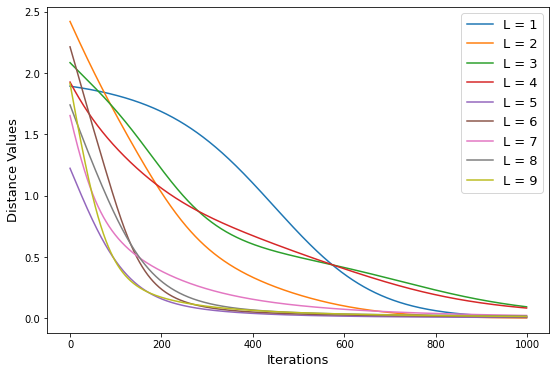

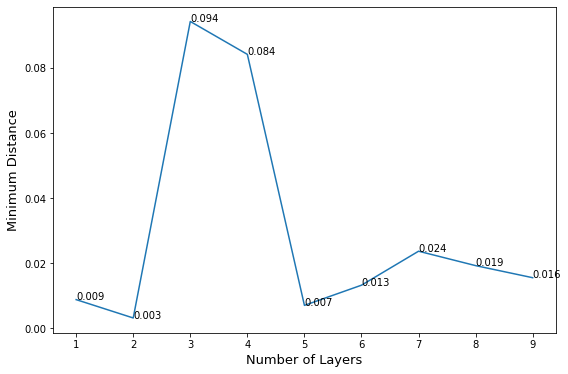

In [26]:
plt.figure(figsize=(9, 6))
min_e = []
number_of_L = []
for l in range(1,10):
  with open('/content/mydrive/layer_{}'.format(l)) as f:
      evalues  = f.read().splitlines()
  evalues = [float(i) for i in evalues]
  min_e .append(evalues[len(evalues)-1])
  number_of_L.append(l)
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(evalues,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(number_of_L,min_e)
for i in range(len(min_e)): plt.annotate(np.around(min_e[i], 3), (number_of_L[i], min_e[i]))
plt.xlabel("Number of Layers", fontsize=13)
plt.ylabel("Minimum Distance", fontsize=13)
plt.show()

In [ ]:
np.loadtxt(c, delimiter=',')

#### Bonus part
Now let's see what happens if other kinds of circuits used for implementing the QNN. The following circuit is replaced with the previous design for implementing each layer of the QNN, based on [Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms](https://arxiv.org/pdf/1905.10876.pdf).

<img src = "Figures/c2.png" style = "width:400px"/>

So I change *generate_even_block* and *generate_odd_block* functions by adding one extra arguments *types* that determine which type of circuits is generated. Also, the default value 1  is assigned for *types*. 

In [12]:
def generate_even_block(block_number,types = 1):
    """ Function for generating the even blocks
        Arguments:
          block_number: Block number, it has to be even.
        return: ciq.Circuit """
    if (types == 1):
        params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*4,block_number*4)])

        # create the parameterized circuit
        circuit = cirq.Circuit(
            cirq.rz(params[0])(qubits[0]),
            cirq.rz(params[1])(qubits[1]),
            cirq.rz(params[2])(qubits[2]),
            cirq.rz(params[3])(qubits[3]),
            cirq.CZ(qubits[0],qubits[1]),
            cirq.CZ(qubits[0],qubits[2]),
            cirq.CZ(qubits[0],qubits[3]),
            cirq.CZ(qubits[1],qubits[2]),
            cirq.CZ(qubits[1],qubits[3]),
            cirq.CZ(qubits[2],qubits[3])
        )
    elif(types == 2):
        params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*8,block_number*8)])
        
        circuit = cirq.Circuit(
            cirq.ry(params[0])(qubits[0]),
            cirq.ry(params[1])(qubits[1]),
            cirq.ry(params[2])(qubits[2]),
            cirq.ry(params[3])(qubits[3]),
            cirq.CNOT(qubits[3], qubits[2]) ** params[4],
            cirq.CNOT(qubits[0], qubits[3]) ** params[5],
            cirq.CNOT(qubits[1], qubits[0]) ** params[6],
            cirq.CNOT(qubits[2], qubits[1]) ** params[7]
        )
    else:
        print("Only types 1 and 2 are supported!")
        return cirq.Circuit()
    return circuit

In [13]:
def generate_odd_block(block_number, types = 1):
    """ Function for generating the odd blocks
        block_number: Block number, it has to be odd.
        return: ciq.Circuit """
    if (types == 1):
        params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*4,block_number*4)])

        # create the parameterized circuit
        circuit = cirq.Circuit(
            cirq.rx(params[0])(qubits[0]),
            cirq.rx(params[1])(qubits[1]),
            cirq.rx(params[2])(qubits[2]),
            cirq.rx(params[3])(qubits[3])
        )
    elif(types == 2):
        params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*8,block_number*8)])
        
        circuit = cirq.Circuit(
            cirq.ry(params[0])(qubits[0]),
            cirq.ry(params[1])(qubits[1]),
            cirq.ry(params[2])(qubits[2]),
            cirq.ry(params[3])(qubits[3]),
            cirq.CNOT(qubits[3], qubits[0]) ** params[4],
            cirq.CNOT(qubits[2], qubits[3]) ** params[5],
            cirq.CNOT(qubits[1], qubits[2]) ** params[6],
            cirq.CNOT(qubits[0], qubits[1]) ** params[7]
        )
    else:
        print("Only types 1 and 2 are supported!")
        return cirq.Circuit()
    
    return circuit

In [14]:
def generate_qnn(l,types = 1 ):
    """ Function for generating qnn, containing l number of layers.
        Arguments:
          l: number of layers, each layer contains one odd and one even block.
        return: ciq.Circuit """
    circuit = cirq.Circuit()
    for i in range(1,2*l+1):
        if i % 2 == 1:
            circuit += generate_odd_block(i,types = types)
        else:
            circuit += generate_even_block(i,types = types)
        
    return circuit

Let's see the new model:

In [35]:
l=1
types = 2 
qnn = generate_qnn(l,types = types)
print(qnn)

# Defining and Initializing the parameters:
params = tf.random.uniform(shape = (1,16*l), minval=0, maxval=2*np.pi) #tf.zeros([1,8*l ], tf.float32)
print('Parameters:\n', params)
params_names = sympy.symbols(['theta_{}'.format(n) for n in range(16*l)])

# Calculating the state vector:
state_layer = tfq.layers.State()
state = state_layer(qnn, symbol_names=params_names, symbol_values=params)
print('\nState Vector:\n', state)

(0, 0): ───Ry(theta_0)───X───────────────────────────────────@───────────Ry(theta_8)─────────────────@────────────X─────────────────────────
                         │                                   │                                       │            │
(0, 1): ───Ry(theta_1)───┼───────────────────────@───────────X^theta_7───Ry(theta_9)─────────────────┼────────────@^theta_14───X────────────
                         │                       │                                                   │                         │
(0, 2): ───Ry(theta_2)───┼───────────@───────────X^theta_6───────────────Ry(theta_10)───X────────────┼─────────────────────────@^theta_15───
                         │           │                                                  │            │
(0, 3): ───Ry(theta_3)───@^theta_4───X^theta_5───────────────────────────Ry(theta_11)───@^theta_12───X^theta_13─────────────────────────────
Parameters:
 tf.Tensor(
[[0.99786425 2.5893648  3.3475327  1.3628671  2.7544236  2.29810

In [16]:
np.savetxt('/content/mydrive/model2_params_{}'.format(l), params, delimiter='\n ')

In [33]:
 with open('/content/mydrive/model2_params_1') as f:
    x  = f.read().splitlines()
x = [[float(i) for i in x]]

In [37]:
state = state_layer(qnn, symbol_names=params_names, symbol_values=x)
e = states_distance(state,target_state)
print(e)

tf.Tensor([[2.228401]], shape=(1, 1), dtype=float32)


Now, let's see how this new layers get trained. This model has twice more paramterized gate, and more parameters to train, consequently. Therefore, it is more time consuming than the previous model. Hence, instead of checking QNN with at most 10 layers, I check QNN with at most 6 layers.

In [4]:
L = 6
learning_rate = 0.01
number_of_iteration = 1000
print_step = 100

In [39]:
list_of_e =[]
types = 2
for l in range(1,L+1):
  print('***** Number of Layers:', l, '*****')
  qnn = generate_qnn(l, types)
  params = tf.random.uniform(shape = (1,16*l), minval=0, maxval=2*np.pi) #tf.zeros([1,8*l ], tf.float32)
  params_names = sympy.symbols(['theta_{}'.format(n) for n in range(16*l)])
  eValues = []
  for i in range(number_of_iteration):
    params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/320)
    params = update_params(params, params_grads,learning_rate)

    approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
    e = states_distance(approximation,target_state)
    eValues.append(e[0][0].numpy())

    if i % print_step == 0:
      print('Iteration Number:', i, ', Distance:', e[0][0].numpy())
  print('---Training qnn with ', l, ' layers finished.','Final distance =', e[0][0].numpy(),'.')
  np.savetxt('/content/mydrive/model2_layer_{}'.format(l), eValues, delimiter='\n')
  np.savetxt('/content/mydrive/model2_params_{}'.format(l), params, delimiter='\n ')
  list_of_e.append(eValues)
print('Training finished.')

***** Number of Layers: 1 *****
Iteration Number: 0 , Distance: 2.2417047
Iteration Number: 100 , Distance: 1.2201717
Iteration Number: 200 , Distance: 0.8017386
Iteration Number: 300 , Distance: 0.59037983
Iteration Number: 400 , Distance: 0.43708014
Iteration Number: 500 , Distance: 0.28918684
Iteration Number: 600 , Distance: 0.15915452
Iteration Number: 700 , Distance: 0.07263423
Iteration Number: 800 , Distance: 0.028994339
Iteration Number: 900 , Distance: 0.010807085
---Training qnn with  1  layers finished. Final distance = 0.0039653415 .
***** Number of Layers: 2 *****
Iteration Number: 0 , Distance: 2.0078611
Iteration Number: 100 , Distance: 0.28152537
Iteration Number: 200 , Distance: 0.1718893
Iteration Number: 300 , Distance: 0.120091274
Iteration Number: 400 , Distance: 0.08401838
Iteration Number: 500 , Distance: 0.058970433
Iteration Number: 600 , Distance: 0.041928664
Iteration Number: 700 , Distance: 0.03062285
Iteration Number: 800 , Distance: 0.023262916
Iteration 

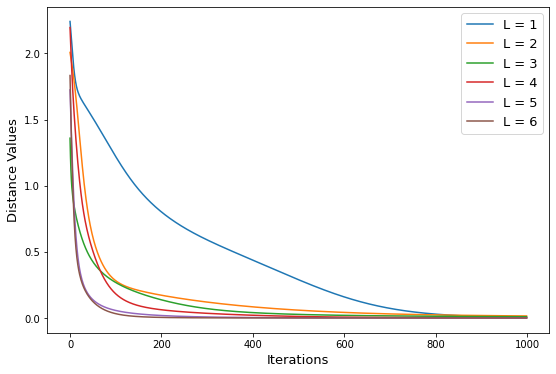

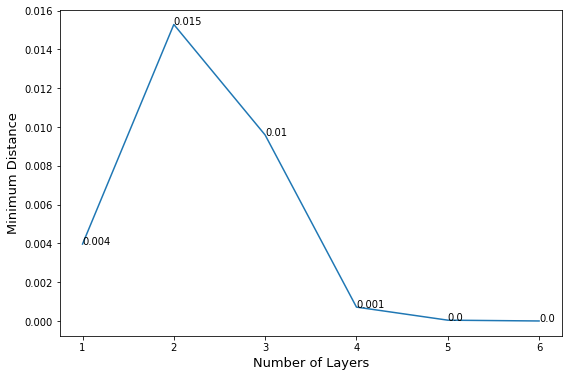

In [28]:
plt.figure(figsize=(9, 6))
min_e = []
number_of_L = []
for l in range(1,L+1):
  with open('/content/mydrive/model2_layer_{}'.format(l)) as f:
      evalues  = f.read().splitlines()
  evalues = [float(i) for i in evalues]
  min_e .append(evalues[len(evalues)-1])
  number_of_L.append(l)
  label='L = {}'.format(l)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(evalues,label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Distance Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(number_of_L,min_e)
for i in range(len(min_e)): plt.annotate(np.around(min_e[i], 3), (number_of_L[i], min_e[i]))
plt.xlabel("Number of Layers", fontsize=13)
plt.ylabel("Minimum Distance", fontsize=13)
plt.show()